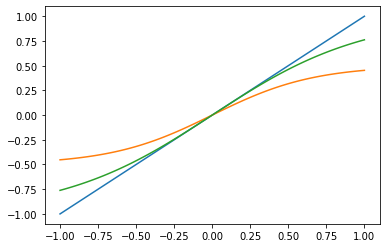

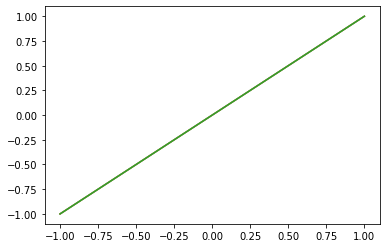

In [89]:
# Test the differentiable inverse function 

import sys
sys.path.append('../../')
import torch
from matplotlib import pyplot as plt
from torchuq.transform.utils import BisectionInverse

def test_func1(val):
    return val

def test_func1_inv(val):
    return val

def test_func2(val):
    return torch.sigmoid(val * 3) - 0.5

def test_func2_inv(val):
    return torch.logit(val + 0.5) / 3.

def test_func3(val):
    return torch.tanh(val)

def test_func3_inv(val):
    return torch.atanh(val)

test_funcs = [test_func1, test_func2, test_func3]
inv_funcs = [test_func1_inv, test_func2_inv, test_func3_inv]
values = torch.linspace(-1, 1, 100)

for test_func, inv_func in zip(test_funcs, inv_funcs):
    plt.plot(values, test_func(values))
plt.show()

for test_func, inv_func in zip(test_funcs, inv_funcs):
    plt.plot(values, inv_func(test_func(values)))
plt.show()  # This should be a straight-line


In [99]:
value_funcs = [lambda: torch.linspace(-1, 1, 100), 
               lambda: torch.linspace(-1, 1, 100).view(1, -1).repeat(2, 1).to(torch.device('cuda:0')),
               lambda: torch.linspace(-1, 1, 100).view(-1, 1, 1).repeat(1, 3, 4)]

for test_func, inv_func in zip(test_funcs, inv_funcs):
    for value_func in value_funcs:
        values = value_func()
        output = test_func(values)
        recon = BisectionInverse(test_func).forward(output)

#         plt.plot(values, recon)
#         plt.plot(values, inv_func(output))

        assert values.shape == recon.shape   # Test for correct shape
        assert values.device == recon.device # Test for correct device
        assert (recon - values).abs().max() < 1e-4      # Test that the construction equals the original input
        assert (recon - inv_func(output)).abs().max() < 1e-4  
        
        # Test the gradients
        values.requires_grad = True
        output = test_func(values)
        recon = BisectionInverse(test_func).forward(output)
        grad_recon = torch.autograd.grad(recon, output, only_inputs=True, retain_graph=True, grad_outputs=torch.ones_like(output))[0]
        
        inv = inv_func(output)
        grad_inv = torch.autograd.grad(inv, output, only_inputs=True, retain_graph=True, grad_outputs=torch.ones_like(output))[0]
        
        assert grad_recon.shape == grad_inv.shape
        assert grad_recon.device == values.device
        assert (grad_recon - grad_inv).abs().max() < 1e-4   # Test for correct gradients
